# Fishing efford time series

In [1]:
# setup

# Import packages
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from itertools import chain

# Initialize google earth engine 
ee.Initialize()

Defining Area of Interest (AoI)

In [2]:
# Complex geometry EEZ of Peru
with open('eez_peru/geojson/eez_peru.geojson') as f:
  geojson = json.load(f)
coords = geojson["features"][0]["geometry"]["coordinates"]

# The resulting List from the geojson file has an extra bracket that we have to remove to be read it as a polygon
aoi = ee.Geometry.Polygon([i for i in chain.from_iterable(coords)])

Reading and filtering data by the AOI and other parameters

In [3]:
# read in the data on fishing hours from google earth engine
dataset = ee.ImageCollection('GFW/GFF/V1/fishing_hours')
# Filter by "WLD" to get all global fishing vessel hours rasters in 2016 by Peru's EEZ extend
effort_all_EEZ = dataset.filterMetadata('country', 'equals', 'WLD')

Combine data by month and year

https://stackoverflow.com/questions/51558121/earth-engine-sst-by-month-and-by-year

In [4]:
startDate = ee.Date('2013-01-01'); # set start time for analysis
endDate = ee.Date('2016-12-31'); # set end time for analysis

# Filter by start and ending date and gear

effort_EEZ = effort_all_EEZ.select("purse_seines").filterDate(startDate, endDate)

# Calculate the number of months to process
nMonths = ee.Number(endDate.difference(startDate,'month')).round();

def map_monthly(n):
    ini = startDate.advance(n,'month') # calculate the offset from startDate
    end = ini.advance(1,'month') # advance just one month
    return (effort_EEZ.filterDate(ini,end) # filter and reduce
                .select(0).sum()
                .set('system:time_start', ini.millis()))


byMonth = ee.ImageCollection(ee.List.sequence(0,nMonths).map(map_monthly))

In [5]:
# See data
result2 = byMonth.getRegion(aoi,25000).getInfo()
# get january (index = 0)
result2_df = pd.DataFrame(result2)
headers = result2_df.loc[0] 
result2_df = pd.DataFrame(result2_df.values[1:], columns = headers)

print(result2_df)
print(sum(result2_df["purse_seines"]))

0      id  longitude   latitude           time purse_seines
0       0 -73.774143 -20.099804  1356998400000            0
1       1 -73.774143 -20.099804  1359676800000            0
2       2 -73.774143 -20.099804  1362096000000            0
3       3 -73.774143 -20.099804  1364774400000            0
4       4 -73.774143 -20.099804  1367366400000            0
...    ..        ...        ...            ...          ...
67963  43 -80.511507  -3.480972  1470009600000            0
67964  44 -80.511507  -3.480972  1472688000000            0
67965  45 -80.511507  -3.480972  1475280000000            0
67966  46 -80.511507  -3.480972  1477958400000            0
67967  47 -80.511507  -3.480972  1480550400000            0

[67968 rows x 5 columns]
188.50692009922568


In [6]:
# Extracting all image values in the collection BY AOI OR POI

def aoi_sum(img):
    sum = img.reduceRegion(reducer=ee.Reducer.sum(), geometry=aoi, 
                           scale=1113.2)#.get('purse_seines') # resolution of the GFW product
    return img.set('time', img.date().millis()).set('sum',sum)

aoi_reduced_imgs = byMonth.map(aoi_sum)
nested_list = aoi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['time','sum']).values().get(0)


In [7]:
# dont forget we need to call the callback method "getInfo" to retrieve the data
df = pd.DataFrame(nested_list.getInfo(), columns=['time','sum'])
df['purse_seines_sum'] = df['sum'].apply(lambda x: x.get('purse_seines'))
df = df.drop(columns='sum').drop(0)
df["id"] = df.index 

# shift column 'C' to first position
first_column = df.pop('id')
# insert column using insert(position,column_name,first_column) function
df.insert(0, 'id', first_column)

df.head()

,id,time,purse_seines_sum
1,1,1359676800000,23.618105
2,2,1362096000000,0.839173
3,3,1364774400000,5.263732
4,4,1367366400000,459.942128
5,5,1370044800000,1063.176510


In [8]:
df['datetime'] = pd.to_datetime(df['time'], unit='ms')
df['datetime'] = pd.to_datetime(df['datetime'],format="%Y%m%d")
df.head()

,id,time,purse_seines_sum,datetime
1,1,1359676800000,23.618105,2013-02-01
2,2,1362096000000,0.839173,2013-03-01
3,3,1364774400000,5.263732,2013-04-01
4,4,1367366400000,459.942128,2013-05-01
5,5,1370044800000,1063.176510,2013-06-01


In [9]:
df['datetime'] = pd.to_datetime(df['datetime'],format="%Y%m%d")
df.head()

,id,time,purse_seines_sum,datetime
1,1,1359676800000,23.618105,2013-02-01
2,2,1362096000000,0.839173,2013-03-01
3,3,1364774400000,5.263732,2013-04-01
4,4,1367366400000,459.942128,2013-05-01
5,5,1370044800000,1063.176510,2013-06-01


Text(0, 0.5, 'hours/sq. km')

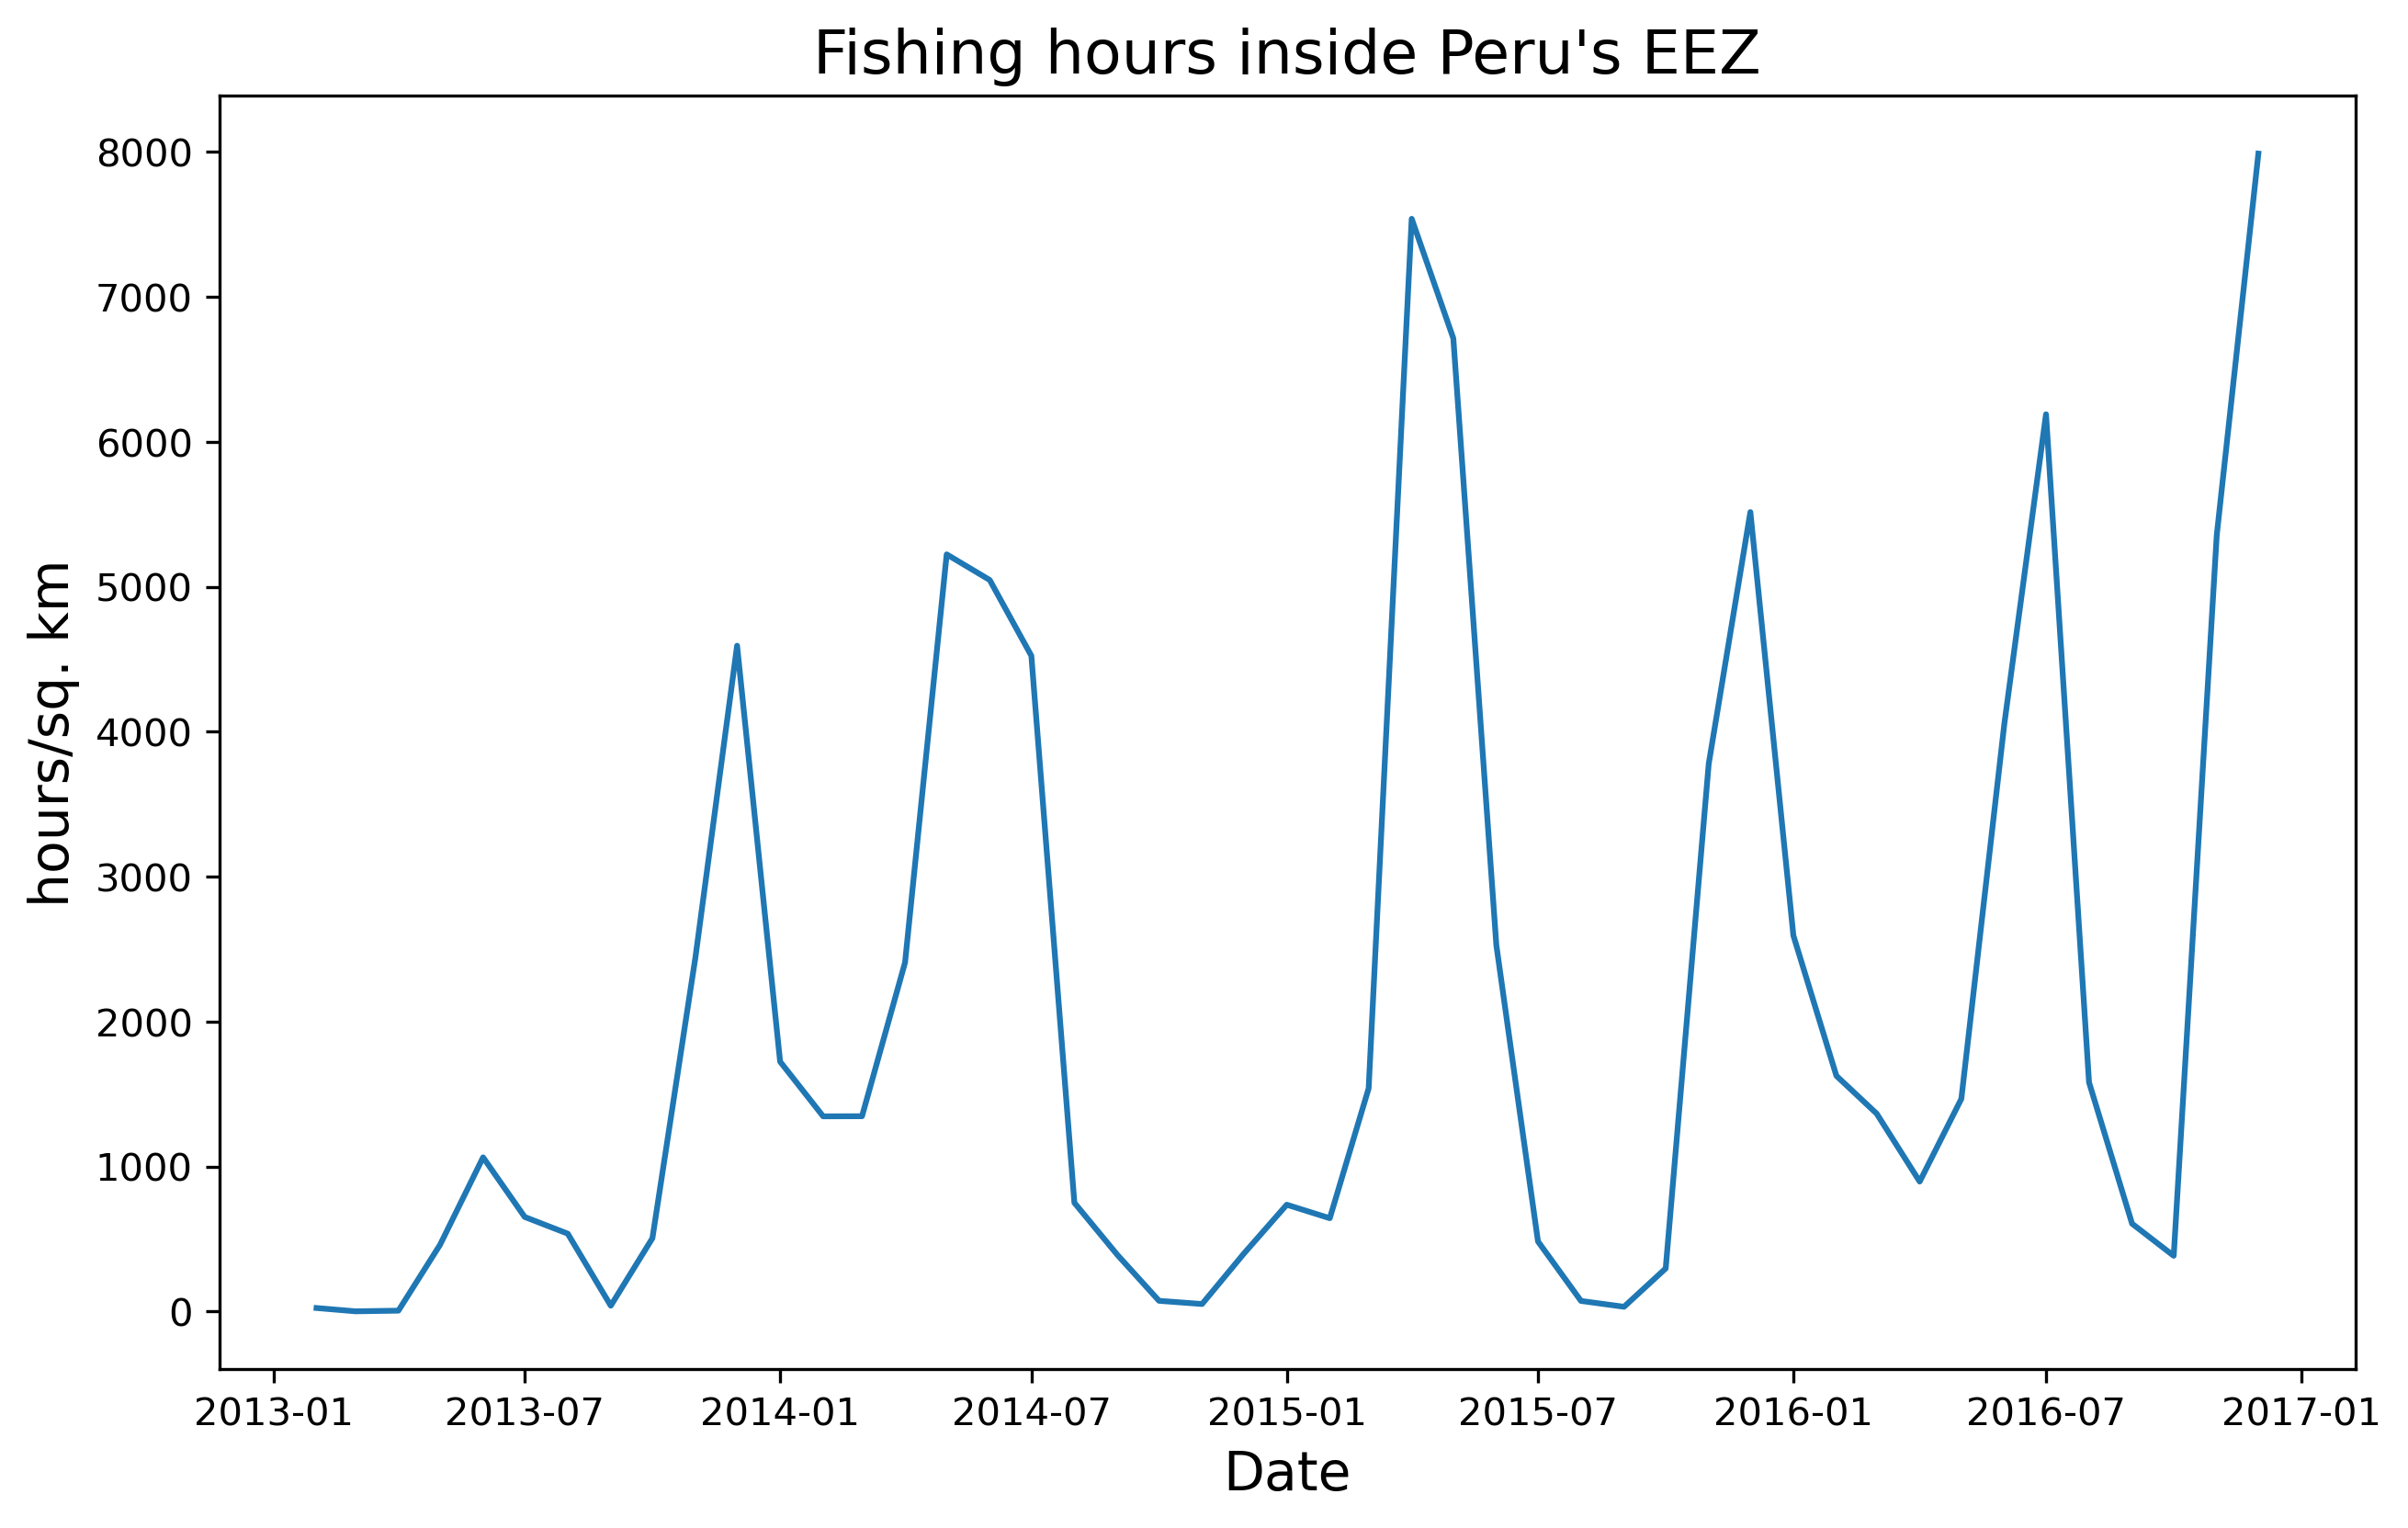

In [10]:
plt.figure(figsize=(10, 6), dpi=300)    # create a new figure, set size and resolution (dpi)
plt.plot(df['datetime'],df['purse_seines_sum'])   # add data to the plot
plt.title("Fishing hours inside Peru's EEZ", fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('hours/sq. km', fontsize=14)


## Time series for the area beyond EEZ

In [11]:
# Setting new AOI including areas beyond the EEZ
geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -89.8703470212856,
              -2.9010789371311176
            ],
            [
              -89.8703470212856,
              -19.936548732128458
            ],
            [
              -70.081492068508,
              -19.936548732128458
            ],
            [
              -70.081492068508,
              -2.9010789371311176
            ],
            [
              -89.8703470212856,
              -2.9010789371311176
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}
coords = geojson["features"][0]["geometry"]["coordinates"]
aoi = ee.Geometry.Polygon(coords)


# Extracting all image values in the collection by the new AOI 
def aoi_sum(img):
    sum = img.reduceRegion(reducer=ee.Reducer.sum(), geometry=aoi, 
                           scale=1113.2)#.get('purse_seines') # resolution of the GFW product
    return img.set('time', img.date().millis()).set('sum',sum)

aoi_reduced_imgs = byMonth.map(aoi_sum)
nested_list = aoi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['time','sum']).values().get(0)

In [12]:

# Transform data to pandas and rearrange the dataframe
df = pd.DataFrame(nested_list.getInfo(), columns=['time','sum'])
df['purse_seines_sum'] = df['sum'].apply(lambda x: x.get('purse_seines'))
df = df.drop(columns='sum').drop(0)
df["id"] = df.index 
first_column = df.pop('id')
df.insert(0, 'id', first_column)

# Set time format
df['datetime'] = pd.to_datetime(df['time'], unit='ms')
df['datetime'] = pd.to_datetime(df['datetime'],format="%Y%m%d")
df.head()

,id,time,purse_seines_sum,datetime
1,1,1359676800000,725.304517,2013-02-01
2,2,1362096000000,233.586406,2013-03-01
3,3,1364774400000,376.594187,2013-04-01
4,4,1367366400000,1059.850572,2013-05-01
5,5,1370044800000,1126.965315,2013-06-01


Text(0, 0.5, 'hours/sq. km')

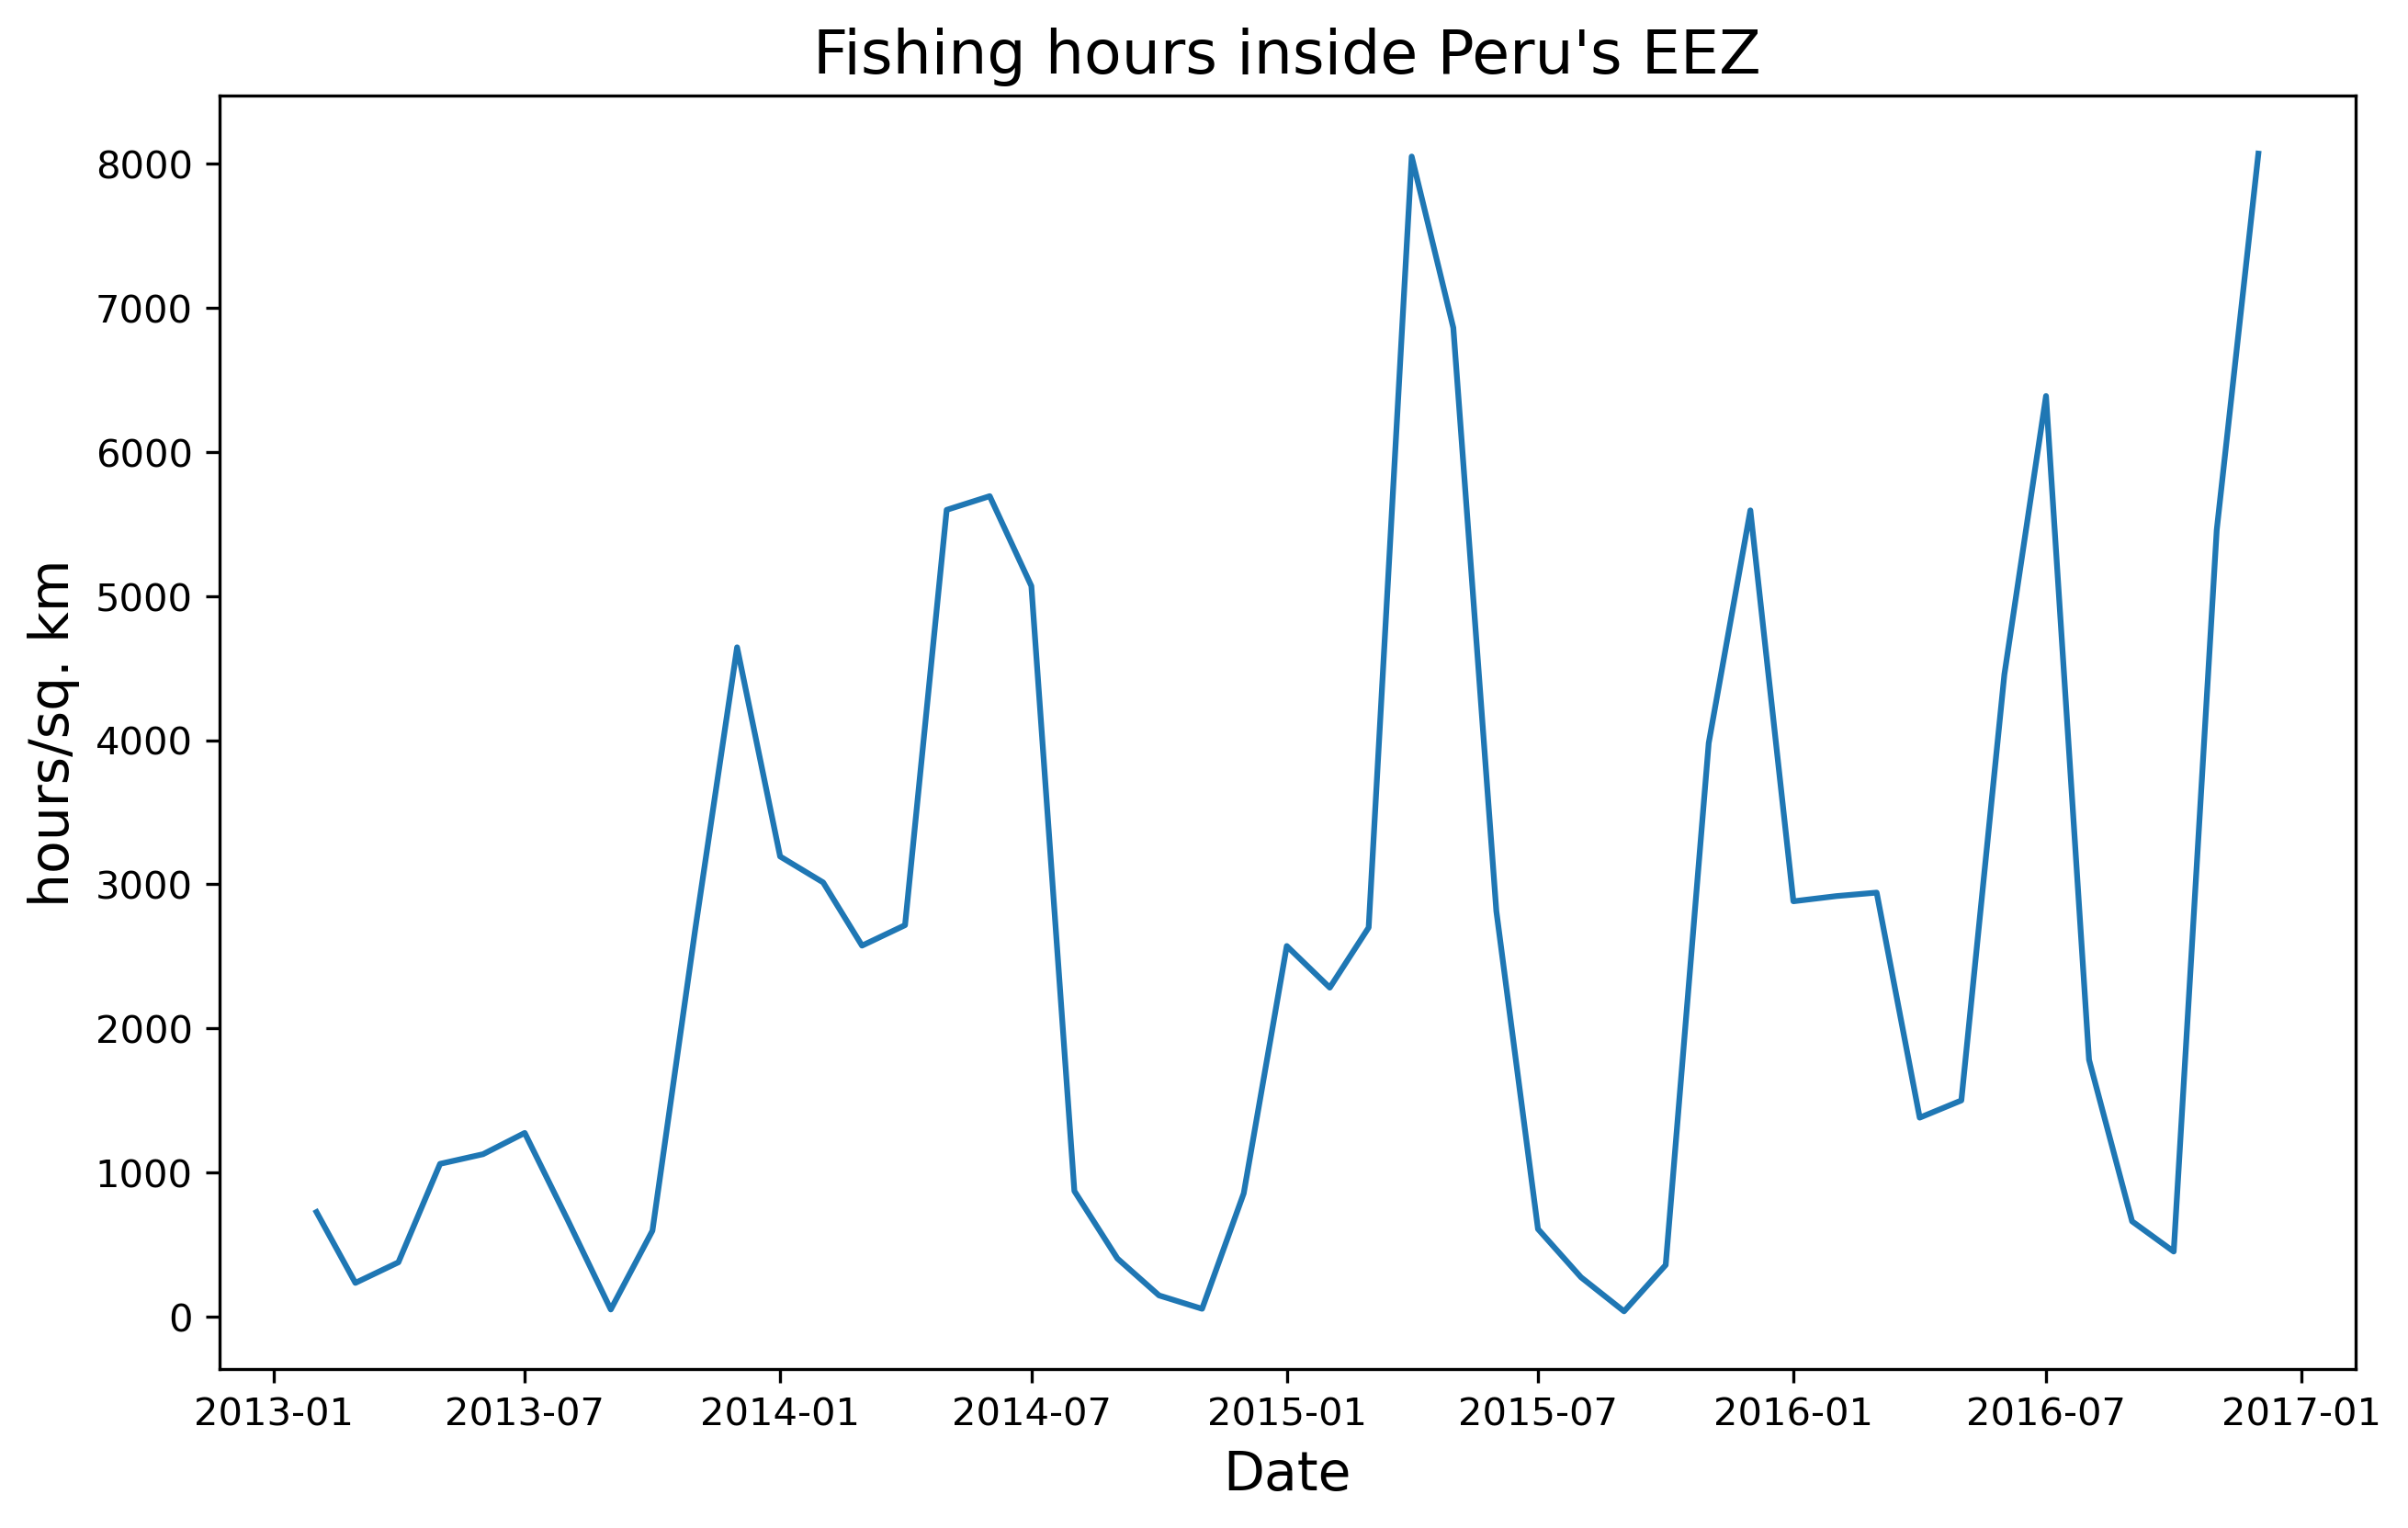

In [13]:
plt.figure(figsize=(10, 6), dpi=300)    # create a new figure, set size and resolution (dpi)
plt.plot(df['datetime'],df['purse_seines_sum'])   # add data to the plot
plt.title("Fishing hours inside Peru's EEZ", fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('hours/sq. km', fontsize=14)

## Total fishing not just purse seines

In [14]:
# read in the data on fishing hours from google earth engine
dataset = ee.ImageCollection('GFW/GFF/V1/fishing_hours')
# Filter by "WLD" to get all global fishing vessel hours rasters in 2016 by Peru's EEZ extend
effort_all_EEZ = dataset.filterMetadata('country', 'equals', 'WLD') \
        .filterBounds(aoi) \
            .map(lambda image: image.clip(aoi))

In [15]:
startDate = ee.Date('2013-01-01'); # set start time for analysis
endDate = ee.Date('2016-12-31'); # set end time for analysis

# Filter by start and ending date and gear

effort_EEZ = effort_all_EEZ.filterDate(startDate, endDate)

# Calculate the number of months to process
nMonths = ee.Number(endDate.difference(startDate,'month')).round();

def map_monthly(n):
    ini = startDate.advance(n,'month') # calculate the offset from startDate
    end = ini.advance(1,'month') # advance just one month
    aggregate = (effort_EEZ.filterDate(ini,end) # filter and reduce
                .sum())
    #sum_bands = (aggregate.reduce(ee.Reducer.sum()))
    return (aggregate.set('system:time_start', ini)) #.millis()

byMonth = ee.ImageCollection(ee.List.sequence(0,nMonths).map(map_monthly))


def sum_bands(n):
    ini = startDate.advance(n,'month') # calculate the offset from startDate
    end = ini.advance(1,'month') # advance just one month
    sum_bands = (byMonth.filterDate(ini,end)
                .reduce(ee.Reducer.sum()))
    return (sum_bands.set('system:time_start', ini.millis()))

all_bands_byMonth = ee.ImageCollection(ee.List.sequence(0,nMonths).map(sum_bands))

# ['drifting_longlines', 'fixed_gear', 'other_fishing', 'purse_seines', 'squid_jigger', 'trawlers']


In [16]:
ini = startDate.advance(0,'month') # calculate the offset from startDate
end = ini.advance(1,'month') # advance just one month

test = byMonth.filterDate(ini,end)
test = test.reduce(ee.Reducer.sum())
#test = test.sum().reduce(ee.Reducer.sum())



type(test)


ee.image.Image

In [17]:
print(ini.getInfo())
print(end.getInfo())

{'type': 'Date', 'value': 1356998400000}
{'type': 'Date', 'value': 1359676800000}


In [18]:
test = byMonth.first()
bands_list = test.bandNames()
lista = bands_list.getInfo()
print(lista)

['drifting_longlines', 'fixed_gear', 'other_fishing', 'purse_seines', 'squid_jigger', 'trawlers']


In [19]:
# See data
result2 =test.getRegion(aoi,25000).getInfo()
# get january (index = 0)
result2_df = pd.DataFrame(result2)
headers = result2_df.loc[0] 
result2_df = pd.DataFrame(result2_df.values[1:], columns = headers)

print(result2_df.head())
sum(result2_df["purse_seines_sum"])

AttributeError: 'Image' object has no attribute 'getRegion'

In [ ]:
# Extracting all image values in the collection by the new AOI 
def aoi_sum(img):
    sum = img.reduceRegion(reducer=ee.Reducer.sum(), geometry=aoi, 
                           scale=1113.2)#.get('purse_seines') # resolution of the GFW product
    return img.set('time', img.date().millis()).set('sum',sum)

aoi_reduced_imgs = byMonth.map(aoi_sum)
nested_list = aoi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['time','sum']).values().get(0)

Testing (THIS EXTRACTS BY MONTH but allows to reduce the image)
https://gis.stackexchange.com/questions/258344/reduce-image-collection-to-get-annual-monthly-sum-precipitation

In [ ]:
modis = ee.ImageCollection('MODIS/MOD13A1');

months = ee.List.sequence(1, 12);


# my data
startDate = ee.Date('2013-01-01'); # set start time for analysis
endDate = ee.Date('2016-12-31'); # set end time for analysis

# Filter by start and ending date and gear

effort_EEZ = effort_all_EEZ.filterDate(startDate, endDate)

# Calculate the number of months to process
nMonths = ee.Number(endDate.difference(startDate,'month')).round();

months2 = ee.List.sequence(0,nMonths)

# Group by month, and then reduce within groups by mean();
# the result is an ImageCollection with one image for each month.


def by_month(m):
      return (effort_EEZ.filter(ee.Filter.calendarRange(m, m, 'month'))
                    .sum()
                    .reduce(ee.Reducer.sum())
                    .set('system:time_start', ini.millis()))



by_Month = ee.ImageCollection.fromImages(
      months.map(by_month)) # changing months for months2 is what triggers the error

# See data
result2 =by_Month.getRegion(aoi,25000).getInfo()
# get january (index = 0)
result2_df = pd.DataFrame(result2)
headers = result2_df.loc[0] 
result2_df = pd.DataFrame(result2_df.values[1:], columns = headers)

print(result2_df)


0      id  longitude   latitude           time       sum
0       0  -83.88019 -20.099804  1356998400000         0
1       1  -83.88019 -20.099804  1356998400000         0
2       2  -83.88019 -20.099804  1356998400000         0
3       3  -83.88019 -20.099804  1356998400000  0.002976
4       4  -83.88019 -20.099804  1356998400000  0.000424
...    ..        ...        ...            ...       ...
80683   7 -70.180882  -3.031814  1356998400000         0
80684   8 -70.180882  -3.031814  1356998400000         0
80685   9 -70.180882  -3.031814  1356998400000         0
80686  10 -70.180882  -3.031814  1356998400000         0
80687  11 -70.180882  -3.031814  1356998400000         0

[80688 rows x 5 columns]


In [ ]:
sum(result2_df["sum"])

1866.1704672524177

In [ ]:
# Extracting all image values in the collection by the new AOI 
def aoi_sum(img):
    sum = img.reduceRegion(reducer=ee.Reducer.sum(), geometry=aoi, 
                           scale=1113.2)#.get('purse_seines') # resolution of the GFW product
    return img.set('time', img.date().millis()).set('sum',sum)

aoi_reduced_imgs = by_Month.map(aoi_sum)
nested_list = aoi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['time','sum']).values().get(0)

In [ ]:
df = pd.DataFrame(nested_list.getInfo(), columns=['time','sum'])
df

,time,sum
0,1356998400000,{'sum': 54771.37905753181}
1,1356998400000,{'sum': 34332.96700998622}
2,1356998400000,{'sum': 29847.859210992385}
3,1356998400000,{'sum': 58343.74085458426}
4,1356998400000,{'sum': 71681.85895962463}
5,1356998400000,{'sum': 82993.52359941305}
6,1356998400000,{'sum': 108776.2810099206}
7,1356998400000,{'sum': 102132.86710410815}
8,1356998400000,{'sum': 106782.88522194998}
9,1356998400000,{'sum': 97077.13115950837}


In [ ]:
df['purse_seines_sum'] = df['sum'].apply(lambda x: x.get('sum'))
df = df.drop(columns='sum').drop(0)
df["id"] = df.index 
first_column = df.pop('id')
df.insert(0, 'id', first_column)

# Set time format
df['datetime'] = pd.to_datetime(df['time'], unit='ms')
df['datetime'] = pd.to_datetime(df['datetime'],format="%Y%m%d")
df.head()

Jessica's function

In [144]:
# read in the data on fishing hours from google earth engine
dataset = ee.ImageCollection('GFW/GFF/V1/fishing_hours')
# Filter by "WLD" to get all global fishing vessel hours rasters in 2016 by Peru's EEZ extend
effort_all_EEZ = dataset.filterMetadata('country', 'equals', 'WLD') \
        .filterBounds(aoi) \
            .map(lambda image: image.clip(aoi))

years = range(2013,2017)
months = range(1,13)

https://stackoverflow.com/questions/65105717/i-want-to-solve-the-systemtime-start-error-when-trying-to-output-gldas-monthl

In [147]:
def monthly_Sum (collection, years, months):
  effort_sum = []
  for year in years:
    for month in months:
      Monthly_sum = collection.filter(ee.Filter.calendarRange(year, year, 'year')) \
                              .filter(ee.Filter.calendarRange(month, month, 'month')) \
                              .sum() \
                              .reduce(ee.Reducer.sum()) \
                              .set('year', year).set('system:time_start', ee.Date.fromYMD(year, 1, 1))\
                              .set('month', month).set('system:time_start', ee.Date.fromYMD(year, month, 1).millis())
                             
      effort_sum.append (Monthly_sum)
  return ee.ImageCollection.fromImages(effort_sum)

In [148]:
byMonth = monthly_Sum(effort_all_EEZ,years,months)

type(byMonth)

ee.imagecollection.ImageCollection

In [149]:
test = byMonth.first()
bands_list = test.bandNames()
lista = bands_list.getInfo()
print(lista)

['sum']


In [143]:
# See data
result2 =byMonth.getRegion(aoi,25000).getInfo()
# get january (index = 0)
result2_df = pd.DataFrame(result2)
headers = result2_df.loc[0] 
result2_df = pd.DataFrame(result2_df.values[1:], columns = headers)

print(result2_df)


0       id  longitude   latitude                         time       sum
0        0  -83.88019 -20.099804   {'month': 1, 'year': 2013}         0
1        1  -83.88019 -20.099804   {'month': 2, 'year': 2013}         0
2        2  -83.88019 -20.099804   {'month': 3, 'year': 2013}         0
3        3  -83.88019 -20.099804   {'month': 4, 'year': 2013}  0.002976
4        4  -83.88019 -20.099804   {'month': 5, 'year': 2013}         0
...     ..        ...        ...                          ...       ...
295851  39 -70.180882  -3.031814   {'month': 7, 'year': 2016}         0
295852  40 -70.180882  -3.031814   {'month': 8, 'year': 2016}         0
295853  41 -70.180882  -3.031814   {'month': 9, 'year': 2016}         0
295854  42 -70.180882  -3.031814  {'month': 10, 'year': 2016}         0
295855  43 -70.180882  -3.031814  {'month': 11, 'year': 2016}         0

[295856 rows x 5 columns]


In [150]:
# Extracting all image values in the collection by the new AOI 
def aoi_sum(img):
    sum = img.reduceRegion(reducer=ee.Reducer.sum(), geometry=aoi, 
                           scale=1113.2)#.get('purse_seines') # resolution of the GFW product
    return img.set('time', img.date().millis()).set('sum',sum)

aoi_reduced_imgs = byMonth.map(aoi_sum)
nested_list = aoi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['time','sum']).values().get(0)

In [ ]:
df = pd.DataFrame(nested_list.getInfo(), columns=['time','sum'])
df['sum'] = df['sum'].apply(lambda x: x.get('sum'))
df["id"] = df.index 
first_column = df.pop('id')
df.insert(0, 'id', first_column)

# Set time format
df['datetime'] = pd.to_datetime(df['time'], unit='ms')
df['datetime'] = pd.to_datetime(df['datetime'],format="%Y%m%d")
df.head()

Text(0, 0.5, 'hours/sq. km')

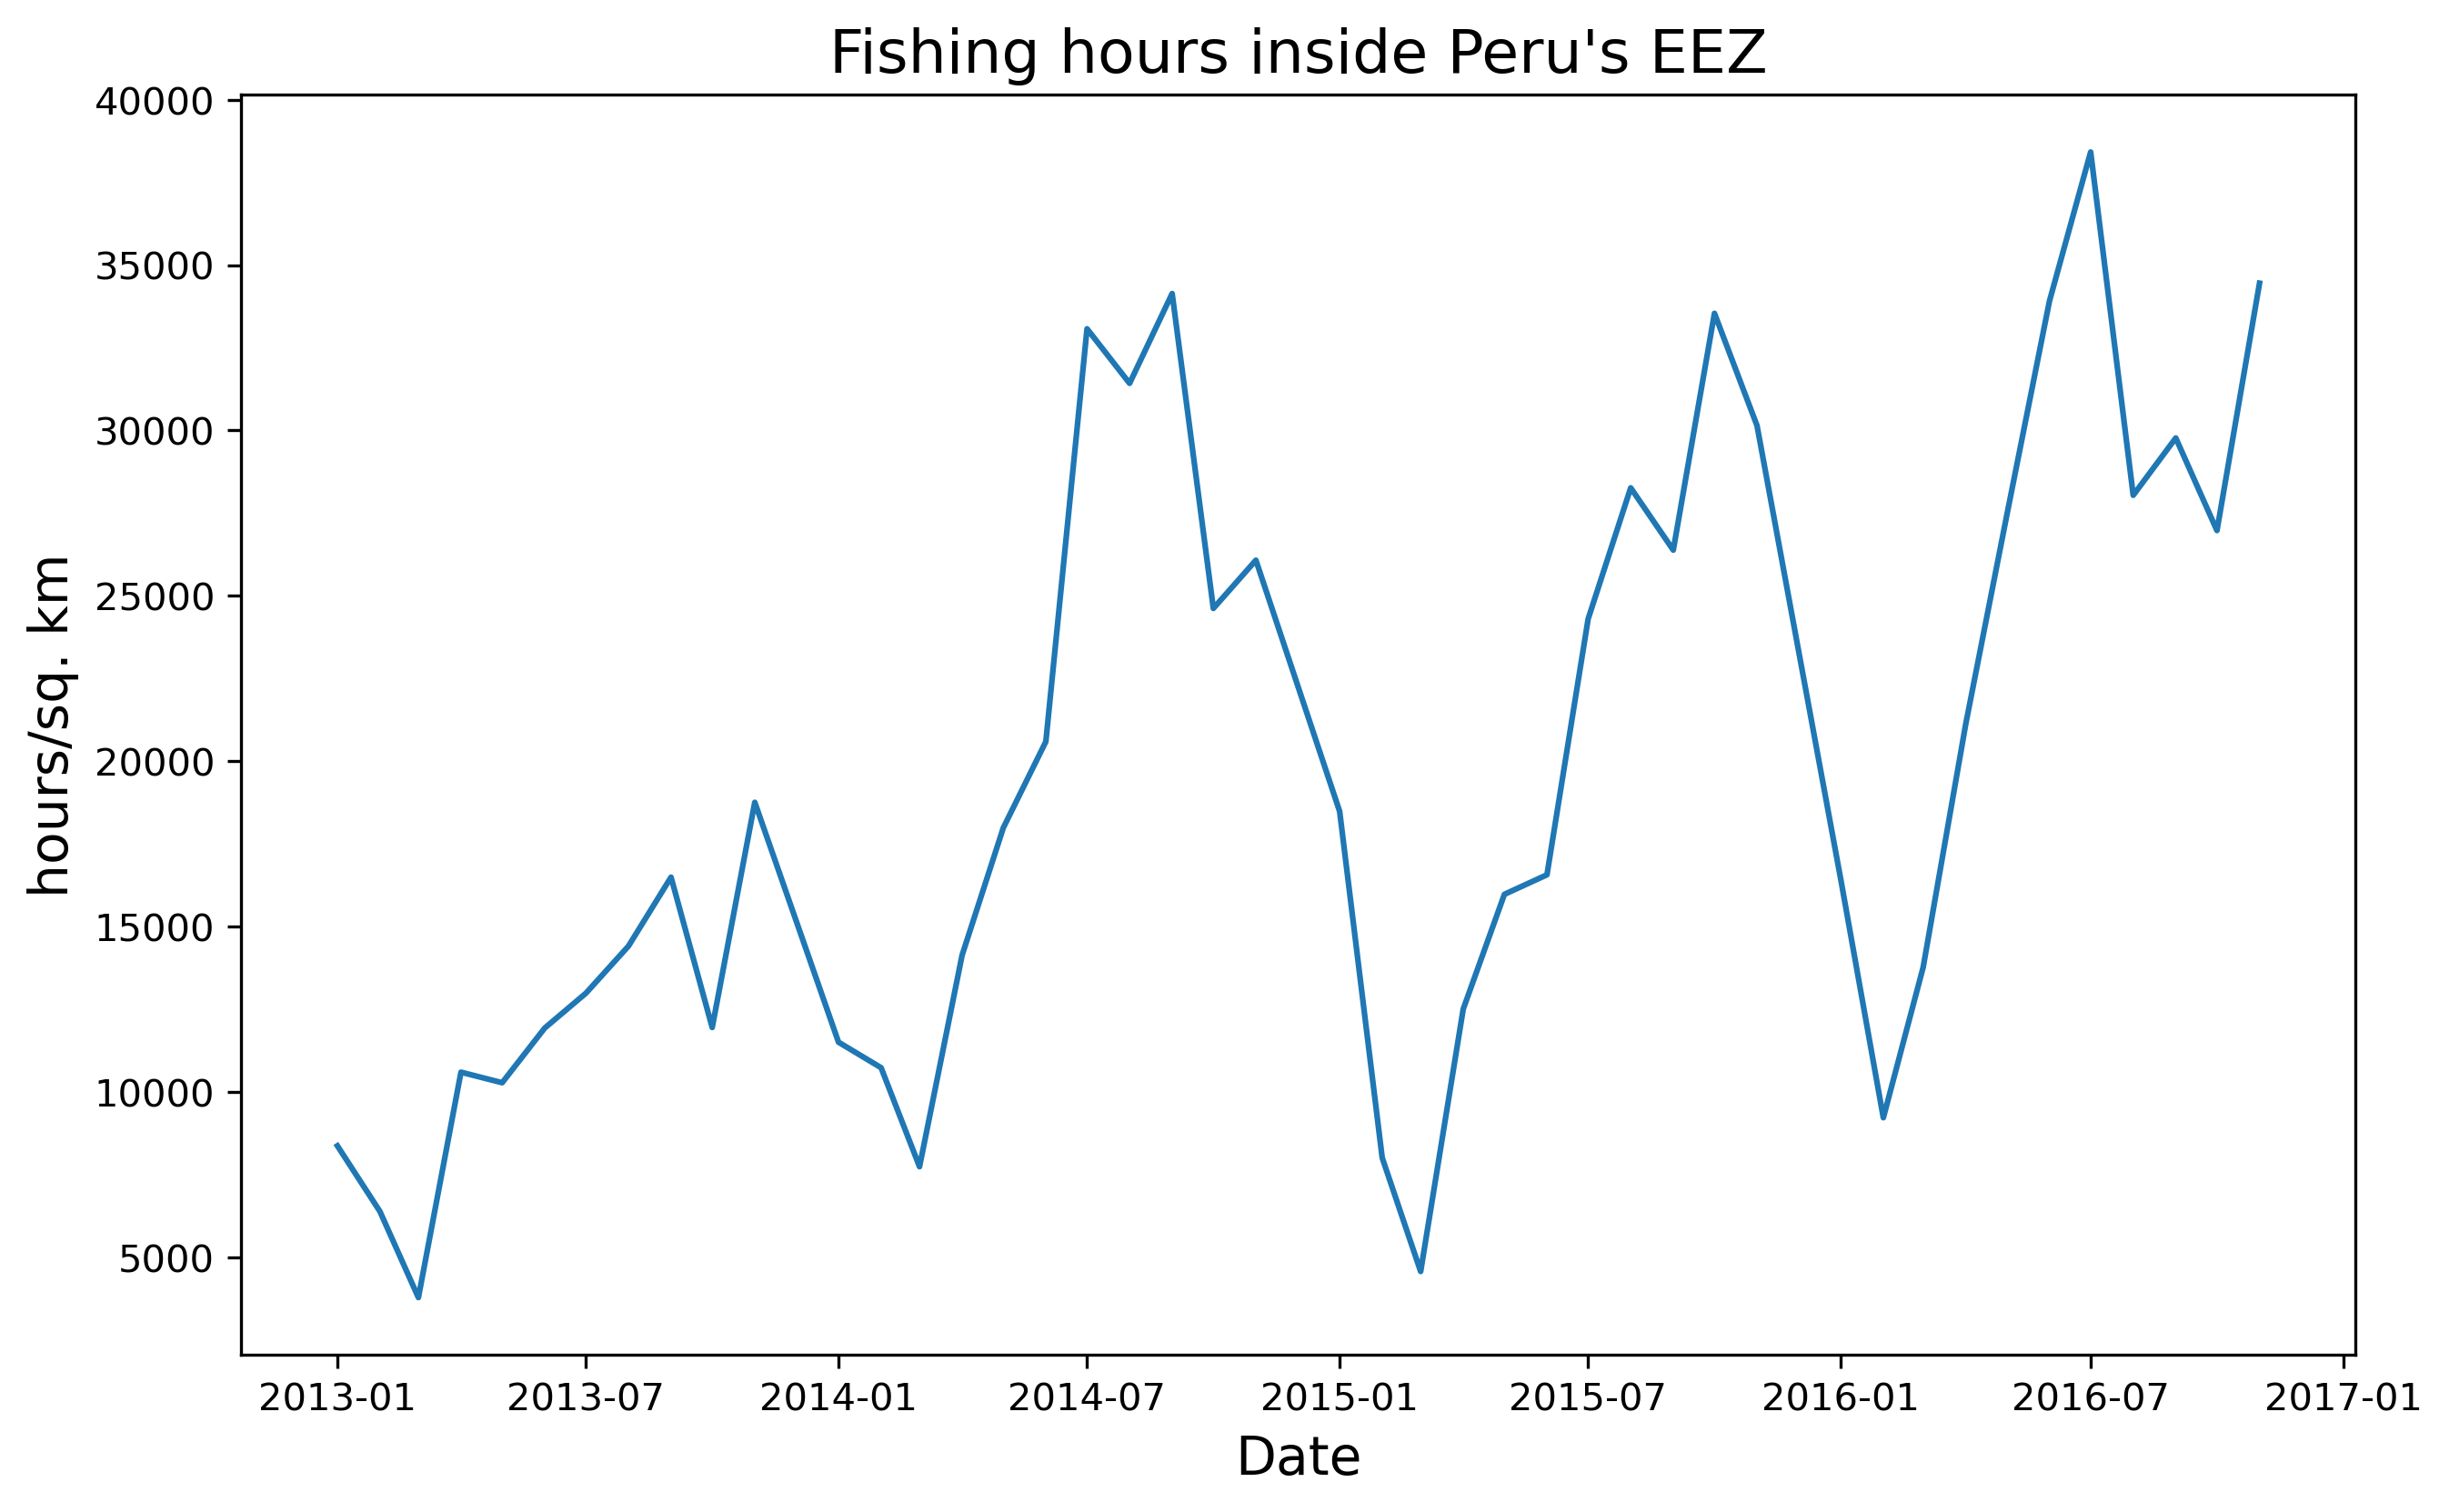

In [135]:
plt.figure(figsize=(10, 6), dpi=300)    # create a new figure, set size and resolution (dpi)
plt.plot(df['datetime'],df['sum'])   # add data to the plot
plt.title("Fishing hours inside Peru's EEZ", fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('hours/sq. km', fontsize=14)

In [ ]:


df["id"] = df.index 
first_column = df.pop('id')
df.insert(0, 'id', first_column)

# Set time format
df['datetime'] = pd.to_datetime(df['time'], unit='ms')
df['datetime'] = pd.to_datetime(df['datetime'],format="%Y%m%d")
df.head()

In [123]:
df = pd.DataFrame(nested_list.getInfo(), columns=['time','sum'])
df

,time,sum
0,1356998400000,{'sum': 8367.286848710319}
1,1359676800000,{'sum': 6381.373815206568}
2,1362096000000,{'sum': 3778.5608580130233}
3,1364774400000,{'sum': 10594.30068857246}
4,1367366400000,{'sum': 10275.589995985683}
5,1370044800000,{'sum': 11928.557808362879}
6,1372636800000,{'sum': 12982.302280066628}
7,1375315200000,{'sum': 14406.80038083205}
8,1377993600000,{'sum': 16490.512256692455}
9,1380585600000,{'sum': 11945.937540218009}
